# Analyze A/B Test Results






## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#conclusion)



<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
# Load file
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the cell below to find the number of rows in the dataset.

In [63]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
# Since converted is a boolean column, True & False are counted as 1 & 0
# Therefore, mean will automatically calculate the proportion of 1s (converted people)
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
# Solution consists of 2 Parts:
# First new page and not classified as treatment
# Second old page and not classified as treatment
df.query('landing_page == "new_page" and group!= "treatment"').shape[0] + df.query('landing_page != "new_page" and group== "treatment"').shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
# No NaNs
# Non-nulls = number of observations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
# Additional check about NaNs
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
# Drop in a 2-stage
# First drop new page that doesn't match treatment from df & store it in df1
# Second drop treatment that doesn't match new page from df1 & store it in df2

df1 = df.drop(df.query('landing_page == "new_page" and group!= "treatment"').index)
df2 = df1.drop(df.query('landing_page != "new_page" and group== "treatment"').index)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated()]

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace = True)

In [17]:
# Check it's now removed
df2[df2.user_id.duplicated()]

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df_control = df2[df2.group == 'control'] # Selecting control from df2
p_control = df_control[df_control.converted == 1].shape[0]/df_control.shape[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df_treatment = df2[df2.group == 'treatment'] # Selecting treatment from df2
p_treatment = df_treatment[df_treatment.converted == 1].shape[0]/df_treatment.shape[0]
p_treatment

0.11880806551510564

#### Actual diffrence in conversions between the treatment group & the control group

In [21]:
actual_diff = p_treatment - p_control
actual_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [22]:
# No. of people who received the new page / total No. of people
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> **Answer:**
- We can preliminary say that there's no evidence that the new page interface yielded more conversions. We can see that the probability of conversion given being in the control group (12.03%) is greater than the probability of conversion given being in the treatment group (11.88%)

<a id='ab_test'></a>
### Part II - A/B Test



`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

1. **$H_{0}$: $p_{new}$ - $p_{old}$ <= 0**
2. **$H_{1}$: $p_{new}$ - $p_{old}$ > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
p_new = df2.query("converted == 1").shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old = df2.query("converted == 1").shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new), p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
(new_page_converted.sum()/n_new) - (old_page_converted.sum()/n_old)

0.00033540165037954095

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new), p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])
    p_diff = (new_page_converted.sum()/n_new) - (old_page_converted.sum()/n_old)
    p_diffs.append(p_diff)

In [31]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

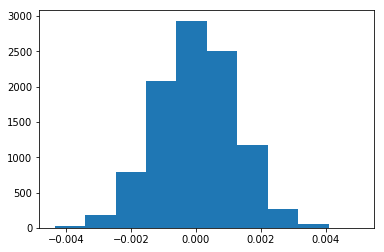

In [32]:
plt.hist(p_diffs);

In [33]:
# St. Dev.
p_diffs.std()

0.001206652678740632

In [34]:
# Size
p_diffs.size

10000

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [35]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

In [36]:
null_vals

array([-0.00079394, -0.00066682,  0.00074953, ..., -0.00099154,
        0.00099599, -0.00126399])

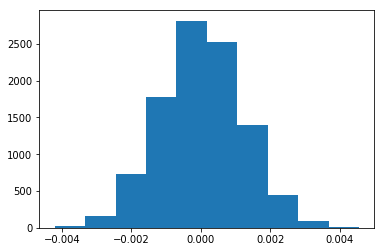

In [37]:
# Plot the null distribution
plt.hist(null_vals);

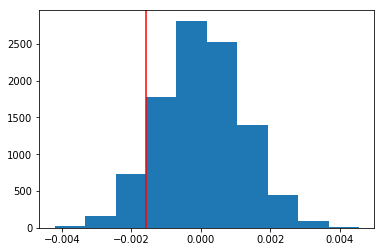

In [38]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(x=actual_diff, color='r'); # The red line is where our statistic lies in the histogram

In [39]:
# Calculate p-value
(null_vals > actual_diff).mean()

0.90739999999999998

**Answer:**
- *The proportion of the p_diffs that is greater than the actual difference*, is **0.91**

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### Answer:
- The above computed value (0.91) is called P-Value
- **Interpretation:** As P-value > alpha (0.05), then we can't reject the null hypothesis that states (conversions from the new web page interface is less than or equal the old one). In other words,  there is no significant difference between the new and old pages.
- **Merely depending on this result, the e-commerce website wouldn't launch the new page. To provide a fruitful analysis, we'd see first how long this experiment was run for.** 

### Should the e-commerce website wait for a longer time to perform a more concrete analysis?
- Here, we'll see how long it took for this experimental new page 

In [64]:
# Check type of timestamp
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
ab_page         290584 non-null uint8
intercept       290584 non-null int64
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


In [65]:
# Convert timestamp column to be Datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

In [66]:
maxtime = df2.timestamp.max()
mintime = df2.timestamp.min()
how_long_period = maxtime - mintime
how_long_period # how long it takes (in days)

Timedelta('21 days 23:59:49.081927')

In [67]:
maxtime

Timestamp('2017-01-24 13:41:54.460509')

In [68]:
mintime

Timestamp('2017-01-02 13:42:05.378582')

#### Conclusion:
- The **experiment** for the new page lasted for **21 days**. It seems a short period for deciding whether or not to launch the new page. Generally speaking, shopping can be subject to seasonal factors. For example, there is a surge in shopping and retailing during Christmas whereas there's a standstill in other times. The experiment was run after the Christmas (from 2 Jan 2017 to 24 Jan 2017) at a time when the shopping boom has subsided. Therefore, there's a risk that this sample doesn't represent the general behavior of customers. **I would recommend to wait for several months (let's say 4 months) so that the analysis can give more reliable insights.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = df2.query("landing_page== 'old_page' and converted ==1").shape[0]
convert_new = df2.query("landing_page== 'new_page' and converted ==1").shape[0]
n_old = df2.query("landing_page== 'old_page'").shape[0]
n_new = df2.query("landing_page== 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [41]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.094941687240975514)

In [62]:
print('P-Value is:', 1-p_value)

P-Value is: 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### **Conclusion:**

> **Z-score (1.31)** is less than the **1.65** threshold for normal distribution with alpha = 0.05, so we can't reject $H_{0}$. Using Z-score is equivalent to using the P-value

> *The **p-value (0.91)** is greater than the type 1 error rate **(0.05)**. It's the same result as in j & k. Therefore, our conclusion is:*
- We fail to reject the null hypothesis (that conversions from the new web page interface is less than or equal the old one)
- In other words, we don't have evidence that the new web page interface yields higher conversions than the old one for the e-commerce website. **Therefore, they shouldn't implement the new page (assuming the experiment was run for an adequate period of time).**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the goal is to ensure that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** Logestic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
# Create dummy for ab_page where treatment=1 & control=0
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head(10) # To check it was done correctly

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   
5   936923  2017-01-10 15:20:49.083499    control     old_page          0   
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   
7   719014  2017-01-17 01:48:29.539573    control     old_page          0   
8   817355  2017-01-04 17:58:08.979471  treatment     new_page          1   
9   839785  2017-01-15 18:11:06.610965  treatment     new_page          1   

   ab_page  
0        0  
1        0  
2        1  
3        1  
4        0  
5        0  
6        1  
7        0  
8        1  
9        1

In [44]:
# Add intercept
df2['intercept'] = 1
df2.head() # To check it was done correctly

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   ab_page  intercept  
0        0          1  
1        0          1  
2        1          1  
3        1          1  
4        0          1

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [45]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-09 08:29 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### Answer:
- **P-value is 0.1899**
- Here in the logistic regression, the null hypothsis ($H_{0}$) is that the ab_page coefficient = 0
- The **baseline** of ab_page coefficient is **treatment**
- As p-value > 0.05, we fail to reject $H_{0}$
- This means that the new page wasn't of great significance, which is equivalent to the A/B Test results where it showed that conversions from the new page were less than or equal to the old page. **Therefore, the e-commerce website shouldn't implement the new page (assuming the experiment was run for an adequate period of time).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### Answer:
> Considering other factors will reinforce the regression results that can be utilized in a better way. For example, getting info about the users' gender, age group, location, and purchasing interests may help in displaying the products they need quickly and more efficiently. This classification would also help in targeting customers' groups which ultimately will yield more conversions

> Adding higher order terms in regression may improve the predictability of our model. However, the regression coefficients won't be easily interpretable

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [47]:
# load data of countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

In [49]:
# What is the list of countries 
countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [50]:
# Merging the 2 dataframes df2 & countries
merged = pd.merge(df2, countries, on='user_id', how='outer')
merged.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   ab_page  intercept country  
0        0          1      US  
1        0          1      US  
2        1          1      US  
3        1          1      US  
4        0          1      US

In [72]:
# See No of rows in df2 and compare it merged
# to insure the merge was done correctly
df2.shape[0]

290584

In [73]:
# Now confirmed
merged.shape[0]

290584

In [51]:
# Create dummy for country
merged[['UK', 'US', 'CA',]] = pd.get_dummies(merged['country'])
merged.head(10) # To check it was done correctly

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   
5   936923  2017-01-10 15:20:49.083499    control     old_page          0   
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   
7   719014  2017-01-17 01:48:29.539573    control     old_page          0   
8   817355  2017-01-04 17:58:08.979471  treatment     new_page          1   
9   839785  2017-01-15 18:11:06.610965  treatment     new_page          1   

   ab_page  intercept country  UK  US  CA  
0        0          1      US   0   0   1  
1        0          1      US   0   0   1  
2        1          1      US   0   0   1  
3        1          1      US   0   0   1  
4        0          1      US   0   0   1  
5        0          1      US   0   0   1  
6        1          1      CA   1   0   0  
7        0          1      US   0   0   1  
8        1          1      UK   0   1   0  
9        1          1      CA   1   0   0

#### Logistic Regression

In [52]:
# Add intercept
merged['intercept'] = 1
merged.head() # To check it was done correctly

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   ab_page  intercept country  UK  US  CA  
0        0          1      US   0   0   1  
1        0          1      US   0   0   1  
2        1          1      US   0   0   1  
3        1          1      US   0   0   1  
4        0          1      US   0   0   1

In [53]:
# Model
log_mod2 = sm.Logit(merged['converted'], merged[['intercept', 'ab_page', 'UK', 'CA']]) # US is the baseline
results2 = log_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [54]:
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-09 08:33 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
CA           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

In [55]:
# Get the values of parameters using exponential
np.exp(results2.params)

intercept    0.138154
ab_page      0.985168
UK           0.950621
CA           0.990165
dtype: float64

#### Conclusion
- Conversion is 0.985 times as likely in the treatment group than the control group, holding other variables constant
- Conversion is 0.95 times as likely in the UK than the USA, holding other variables constant 
- Conversion is 0.95 times as likely in Canada than the USA, holding other variables constant

In [56]:
# The reciprocal can be used to compare the dummies to the baseline
1/(np.exp(results2.params))

intercept    7.238314
ab_page      1.015056
UK           1.051944
CA           1.009932
dtype: float64

#### Conclusion
- Conversion is 1.015 times as likely in the control group than the treatment group, holding other variables constant
- Conversion is 1.05 times as likely in the USA than the UK, holding other variables constant 
- Conversion is 1.01 times as likely in the USA than the Canada, holding other variables constant

> **Said differently**, customers who receive the old page generate more conversions to the e-commerce website than those who receive the new page.
> In general, Customers from the US generate more conversions, than coustomers from CA & UK 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [58]:
# Create interactions
merged['abpage_uk'] = merged['ab_page']*merged['UK']
merged['abpage_ca'] = merged['ab_page']*merged['CA']
merged.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   ab_page  intercept country  UK  US  CA  abpage_uk  abpage_ca  
0        0          1      US   0   0   1          0          0  
1        0          1      US   0   0   1          0          0  
2        1          1      US   0   0   1          0          1  
3        1          1      US   0   0   1          0          1  
4        0          1      US   0   0   1          0          0

In [59]:
# Model
log_mod3 = sm.Logit(merged['converted'], merged[['intercept', 'ab_page', 'UK', 'CA', 'abpage_uk', 'abpage_ca']])
results3 = log_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [60]:
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-09 08:44 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
UK           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
abpage_uk    -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
abpage_ca    -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

#### Conclusion
- The coefficients of interactions were insignificant (p-values > 0.05)
- With the higher order term (interactions in this case), the coefficients associated with new page (ab_page) and countries are not easily interpretable.

<a id='conclusion'></a>
### Part IV - Conclusion

#### A/B Testing Results:


- **Statistical Significance:** 

> As **P-value > alpha (0.05)**, then we **can't reject the null hypothesis** that states (conversions from the new web page interface is less than or equal the old one). In other words,  there is no significant difference between the new and old pages.

> Merely depending on this result, the e-commerce website shouldn't launch the new page.

- **Practical Significance:** 

> The **experiment** for the new page lasted for **21 days**. It seems a short period for deciding whether or not to launch the new page. Generally speaking, shopping can be subject to seasonal factors. For example, there is a surge in shopping and retailing during Christmas whereas there's a standstill in other times. The experiment was run after the Christmas (from 2 Jan 2017 to 24 Jan 2017) at a time when the shopping boom has subsided. Therefore, there's a risk that this sample doesn't represent the general behavior of customers. 

> ***Due to the lack of sufficient data that represents the truth, I would recommend to wait for several months (let's say 4 months) so that the data can represent different business cycles (from boom to trough) with a wider spectrum of customers, thereby our analysis can give more reliable insights about the appropriate page to adopt .***

<a id='conclusions'></a>

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [2]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0